In [248]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py

# Data EDA

In [249]:
df_1 = pd.read_excel('./kbo_news/HH_2019.xlsx',index_col=0)
df_1.reset_index(drop=True, inplace=True)
df_1.drop(list(df_1[df_1.content == 'if (deployPhase === "local" || deployPhase === "dev") {'].index), inplace=True)
df_1.reset_index(drop=True, inplace=True)

# Gensim Visualization

In [250]:
from tqdm import tqdm_notebook # progress bar
# from konlpy.tag import Mecab #Mecab, Okt 등 형태소 분석기 불러오기
import MeCab
import numpy as np
import string # 특수문자 - 특수문자 제거위해
import re
import warnings # 경고 알림 제거
#import pickle
# gensim이 커졌기 때문에 전체를 import하면 부담된다. 필요한 것만 import
from gensim import corpora  
from gensim import models
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning) # 경고 알림이 뜨면 모두 무시합니다.

In [251]:
import re
mecab = MeCab.Tagger()

def mecab_pos(text):
    pos = []
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+")    # 정규표현식을 반복적으로 사용할 시 compile해서 사용하는게 속도면에서 빠르다..
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    pos = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
        
    return pos



def mecab_morphs(text):
    morphs = []
    
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+") 
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    temp = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
        
    # 추출한 token중에 문자열만 선택.
    for token in temp:
        morphs.append(token[0])
    
    return morphs


def mecab_nouns(text):
    nouns = []
    
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+") 
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    temp = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
        
    # 추출한 token중에 POS가 명사 분류에 속하는 토큰만 선택.
    for token in temp:
        if token[1] == "NNG" or token[1] == "NNP" or token[1] == "NNB" or token[1] == "NNBC" or token[1] == "NP" or token[1] == "NR":
            nouns.append(token[0])
        
    return nouns

In [252]:
def read_documents(input_file_name):
    """문서들을 주어진 이름의 파일로부터 읽어들여 돌려준다."""
    
    corpus = []
    
    corpus.append(input_file_name)
#    with open(input_file_name, 'rb') as f:
#        temp_corpus = pickle.load(f)
#        
#    for page in temp_corpus:
#        corpus += page
    
    return corpus

def text_cleaning(docs):
    # 한국어를 제외한 글자를 제거하는 함수.
    
    cleaned_docs = []
    
    for doc in docs:
        temp_doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", str(doc))
        cleaned_docs.append(temp_doc)

    return cleaned_docs

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    for i in string.punctuation:   # 특수문자 추가
        SW.add(i)

    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding='utf-8') as f:
        for word in f:
            SW.add(word.replace('\n',''))

    return SW


def text_tokenizing(corpus, tokenizer):
    
#     mecab = Mecab()
#     mecab = MeCab.Tagger()
    token_corpus = []
    
    # cleaning하는 방법에는 두 가지가 있다.
#     1. 위에서 처럼 직접 다 제거하는 방법
#     2. 명사만 추출하는 방법 -  명사만 추출하면 대부분 제거된다. 의미는 대부분 명사이다.
    
    if tokenizer == "noun":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):  # desc : 표시글자
            token_text = mecab_nouns(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
                
            token_corpus.append(token_text)
            
    elif tokenized == "morph":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = mecab_morphs(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)

    elif tokenizer == "word":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = corpus[n].split()
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)
        

    return token_corpus


input_file_name = list(df_1.content)
documents = read_documents(input_file_name)
SW = define_stopwords("./stopwords-ko.txt")

cleaned_text = text_cleaning(documents)
tokenized_text = text_tokenizing(cleaned_text, tokenizer="noun") #tokenizer= "noun" or "word", "morph"

In [253]:
stopped_tokens = [i for i in tokenized_text[0] if not i in list(SW)]

In [254]:
# 문서-단어 행렬 만들기
# 어휘(vocabulary) 학습
dictionary = corpora.Dictionary(tokenized_text)  # 단어가 몇 번째인지
# 문서-단어 행렬(document-term matrix) 생성
corpus = [dictionary.doc2bow(text) for text in tokenized_text]  # sklearn의 countervectorize와 동일한 것, word2vec

In [255]:
print(dictionary)

Dictionary(6855 unique tokens: ['가격', '가교', '가까이', '가늠', '가능']...)


In [256]:
for i in dictionary.items():
    print(i)

(0, '가격')
(1, '가교')
(2, '가까이')
(3, '가늠')
(4, '가능')
(5, '가닥')
(6, '가동')
(7, '가랑')
(8, '가량')
(9, '가레')
(10, '가르침')
(11, '가뭄')
(12, '가미')
(13, '가방')
(14, '가서')
(15, '가성')
(16, '가세')
(17, '가속')
(18, '가속도')
(19, '가슴')
(20, '가슴앓이')
(21, '가슴팍')
(22, '가시')
(23, '가시밭길')
(24, '가오')
(25, '가요')
(26, '가용')
(27, '가운데')
(28, '가을')
(29, '가입')
(30, '가정')
(31, '가족')
(32, '가중')
(33, '가지')
(34, '가진')
(35, '가차')
(36, '가치')
(37, '가치관')
(38, '가혹')
(39, '가회')
(40, '각광')
(41, '각도')
(42, '각별')
(43, '각성')
(44, '각오')
(45, '각인')
(46, '각지')
(47, '각축전')
(48, '간격')
(49, '간극')
(50, '간급')
(51, '간담')
(52, '간발')
(53, '간식')
(54, '간접')
(55, '간청')
(56, '간파')
(57, '간판')
(58, '간판타자')
(59, '갈등')
(60, '갈림길')
(61, '갈망')
(62, '갈비뼈')
(63, '갈증')
(64, '감각')
(65, '감감무소식')
(66, '감격')
(67, '감기')
(68, '감내')
(69, '감당')
(70, '감독관')
(71, '감동')
(72, '감량')
(73, '감사')
(74, '감소')
(75, '감수')
(76, '감안')
(77, '감정')
(78, '감정싸움')
(79, '감탄')
(80, '감투')
(81, '감행')
(82, '감회')
(83, '값어치')
(84, '강견')
(85, '강경')
(86, '강경학')
(87, '강공')
(88, '강구')
(89, '강권

(1675, '리거')
(1676, '리그')
(1677, '리더')
(1678, '리더십')
(1679, '리드')
(1680, '리드오프')
(1681, '리듬')
(1682, '리딩')
(1683, '리빌')
(1684, '리셋')
(1685, '리스크')
(1686, '리스트')
(1687, '리조')
(1688, '리진')
(1689, '리츠')
(1690, '리터치')
(1691, '리턴')
(1692, '리틀')
(1693, '리티')
(1694, '리포트')
(1695, '리플레이')
(1696, '리회')
(1697, '릭스')
(1698, '린드')
(1699, '린스키')
(1700, '릴레이')
(1701, '릴리스')
(1702, '릴리프')
(1703, '링크')
(1704, '마감')
(1705, '마구잡이')
(1706, '마님')
(1707, '마다')
(1708, '마당')
(1709, '마당쇠')
(1710, '마디')
(1711, '마라')
(1712, '마련')
(1713, '마리')
(1714, '마린스')
(1715, '마무리')
(1716, '마법')
(1717, '마산')
(1718, '마산회원구')
(1719, '마수걸이')
(1720, '마스코트')
(1721, '마스크')
(1722, '마스터')
(1723, '마스터키')
(1724, '마운드')
(1725, '마움')
(1726, '마음')
(1727, '마음가짐')
(1728, '마음고생')
(1729, '마음속')
(1730, '마이')
(1731, '마이너')
(1732, '마이너스')
(1733, '마이카')
(1734, '마이크')
(1735, '마이클')
(1736, '마인드')
(1737, '마일영')
(1738, '마주')
(1739, '마지노선')
(1740, '마지막')
(1741, '마진')
(1742, '마찬가지')
(1743, '마찰')
(1744, '마침표')
(1745, '마케팅')
(1746, '마켓')
(1747, '마크')
(

(3748, '엔트리')
(3749, '엘리트')
(3750, '엘지')
(3751, '엠블럼')
(3752, '엠스')
(3753, '여건')
(3754, '여건욱')
(3755, '여기저기')
(3756, '여년')
(3757, '여념')
(3758, '여동생')
(3759, '여럿')
(3760, '여론')
(3761, '여름')
(3762, '여름철')
(3763, '여름휴가')
(3764, '여만')
(3765, '여명')
(3766, '여분')
(3767, '여사')
(3768, '여성')
(3769, '여세')
(3770, '여신')
(3771, '여운')
(3772, '여유')
(3773, '여일')
(3774, '여정')
(3775, '여지')
(3776, '여타')
(3777, '여파')
(3778, '여행')
(3779, '역경')
(3780, '역대')
(3781, '역동작')
(3782, '역량')
(3783, '역모션')
(3784, '역발상')
(3785, '역부족')
(3786, '역사')
(3787, '역설')
(3788, '역순')
(3789, '역시')
(3790, '역임')
(3791, '역적')
(3792, '역전')
(3793, '역전극')
(3794, '역전승')
(3795, '역전패')
(3796, '역점')
(3797, '역투')
(3798, '역할')
(3799, '연간')
(3800, '연결')
(3801, '연계')
(3802, '연고')
(3803, '연고지')
(3804, '연골')
(3805, '연관')
(3806, '연구')
(3807, '연기')
(3808, '연도')
(3809, '연락')
(3810, '연령')
(3811, '연마')
(3812, '연맹')
(3813, '연발')
(3814, '연봉')
(3815, '연상')
(3816, '연세대')
(3817, '연속')
(3818, '연쇄')
(3819, '연수')
(3820, '연습')
(3821, '연습장')
(3822, '연승')
(3823

(5679, '촉발')
(5680, '촉진')
(5681, '촌극')
(5682, '총괄')
(5683, '총동원')
(5684, '총력')
(5685, '총력전')
(5686, '총사')
(5687, '총액')
(5688, '총원')
(5689, '총재')
(5690, '총제')
(5691, '총체')
(5692, '총출동')
(5693, '총평')
(5694, '촬영')
(5695, '최강')
(5696, '최고')
(5697, '최고참')
(5698, '최근')
(5699, '최다')
(5700, '최대')
(5701, '최대치')
(5702, '최대한')
(5703, '최동환')
(5704, '최문영')
(5705, '최상')
(5706, '최상급')
(5707, '최상위')
(5708, '최선')
(5709, '최성영')
(5710, '최소')
(5711, '최소한')
(5712, '최수원')
(5713, '최승')
(5714, '최신식')
(5715, '최악')
(5716, '최연소')
(5717, '최연희')
(5718, '최영진')
(5719, '최영환')
(5720, '최우선')
(5721, '최우수')
(5722, '최원준')
(5723, '최원태')
(5724, '최윤석')
(5725, '최인영')
(5726, '최인호')
(5727, '최일언')
(5728, '최장')
(5729, '최재구')
(5730, '최재홍')
(5731, '최재훈')
(5732, '최저')
(5733, '최적기')
(5734, '최정')
(5735, '최정용')
(5736, '최정은')
(5737, '최정화')
(5738, '최종')
(5739, '최주환')
(5740, '최준')
(5741, '최준용')
(5742, '최진석')
(5743, '최진행')
(5744, '최진형')
(5745, '최창환')
(5746, '최채')
(5747, '최초')
(5748, '최충연')
(5749, '최하위')
(5750, '최하위권')
(5751, '최항')
(5752, '

In [257]:
corpus[0] # (index, word frequency)

[(0, 3),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 272),
 (5, 1),
 (6, 44),
 (7, 1),
 (8, 15),
 (9, 1),
 (10, 4),
 (11, 8),
 (12, 2),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 11),
 (17, 1),
 (18, 2),
 (19, 18),
 (20, 1),
 (21, 5),
 (22, 4),
 (23, 3),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 271),
 (28, 75),
 (29, 8),
 (30, 7),
 (31, 97),
 (32, 7),
 (33, 54),
 (34, 1),
 (35, 1),
 (36, 14),
 (37, 3),
 (38, 6),
 (39, 1),
 (40, 1),
 (41, 10),
 (42, 2),
 (43, 2),
 (44, 65),
 (45, 1),
 (46, 2),
 (47, 1),
 (48, 12),
 (49, 2),
 (50, 1),
 (51, 1),
 (52, 3),
 (53, 4),
 (54, 3),
 (55, 1),
 (56, 2),
 (57, 7),
 (58, 10),
 (59, 19),
 (60, 2),
 (61, 1),
 (62, 2),
 (63, 7),
 (64, 29),
 (65, 1),
 (66, 19),
 (67, 1),
 (68, 1),
 (69, 7),
 (70, 1),
 (71, 31),
 (72, 2),
 (73, 74),
 (74, 13),
 (75, 18),
 (76, 22),
 (77, 33),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 3),
 (82, 7),
 (83, 4),
 (84, 1),
 (85, 2),
 (86, 229),
 (87, 4),
 (88, 3),
 (89, 1),
 (90, 1),
 (91, 1),
 (92, 1),
 (93, 3),
 (94, 3),
 (95, 10),
 (96, 34),
 (97, 75),


In [258]:
# TFIDF 문서-단어 행렬 생성
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
corpus_tfidf[0]

[]

In [259]:
model = models.ldamodel.LdaModel(corpus, num_topics=4, id2word=dictionary)

In [260]:
# LDA 결과 확인
model.show_topic(3, 10)  # show_topic(topic_no, wordsofnum) - n번 topic의 단어확률값을 보여준다..

[('선발', 0.014903593),
 ('안타', 0.014629517),
 ('이닝', 0.013301388),
 ('홈런', 0.011249085),
 ('리그', 0.009955171),
 ('투수', 0.009924896),
 ('타자', 0.009458841),
 ('승리', 0.008385909),
 ('실점', 0.0079256315),
 ('이날', 0.007767594)]

In [261]:
# 토픽 개수, 키워드 개수를 정해주는 변수를 추가.
NUM_TOPICS = 6

NUM_TOPIC_WORDS = 20


def build_doc_term_mat(documents):
    # 문서-단어 행렬 만들어주는 함수.
    print("Building document-term matrix.")
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]
        
    return corpus, dictionary


def print_topic_words(model):

    # 토픽 모델링 결과를 출력해 주는 함수.
    print("\nPrinting topic words.\n")
    
    for topic_id in range(model.num_topics):
        topic_word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)
        print("Topic ID: {}".format(topic_id))
        
        for topic_word, prob in topic_word_probs:
            print("\t{}\t{}".format(topic_word, prob))
            
        print("\n")

# document-term matrix를 만들고,
corpus, dictionary = build_doc_term_mat(tokenized_text)
# LDA를 실행.
model = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, alpha="auto", eta="auto")
# 결과를 출력.
print_topic_words(model)

Building document-term matrix.

Printing topic words.

Topic ID: 0
	안타	0.01654805801808834
	이닝	0.014998644590377808
	승리	0.013212437741458416
	선발	0.012935991398990154
	실점	0.011422288604080677
	기록	0.011336242780089378
	투수	0.01042153500020504
	리그	0.009943878278136253
	홈런	0.008165261708199978
	타점	0.007426406256854534
	타자	0.0074095940217375755
	볼넷	0.007345566991716623
	등판	0.006480511277914047
	이날	0.00593407591804862
	정은원	0.005821524653583765
	서폴드	0.005510691087692976
	송광민	0.00535265076905489
	삼진	0.005101312883198261
	김태균	0.005014282651245594
	이성열	0.004977583419531584


Topic ID: 1
	안타	0.019857756793498993
	선발	0.01777677983045578
	홈런	0.014520353637635708
	리그	0.011906241998076439
	이닝	0.009015918709337711
	타자	0.00892347376793623
	투수	0.00872145313769579
	볼넷	0.008211789652705193
	승리	0.007597274612635374
	실점	0.007102092728018761
	정은원	0.006950379814952612
	기록	0.006923035252839327
	등판	0.006806901656091213
	타점	0.006073119584470987
	서폴드	0.005945205222815275
	김태균	0.005734655074775219
	상대	0.00559776928

In [262]:
# pyLDAvis 불러오기
import pyLDAvis
import pyLDAvis.gensim


# pyLDAvis를 jupyter notebook에서 실행할 수 있게 활성화.
pyLDAvis.enable_notebook()

# pyLDAvis 실행.
data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.003360  0.002865       1        1  63.127075
5     -0.001129 -0.000869       2        1  16.181448
0     -0.002115 -0.000364       3        1  10.914074
3      0.000282 -0.003762       4        1   5.051682
2      0.002045  0.000075       5        1   3.130265
1      0.004275  0.002055       6        1   1.595454, topic_info=     Term         Freq        Total Category  logprob  loglift
3572   안타  3708.000000  3708.000000  Default  30.0000  30.0000
2844   선발  3574.000000  3574.000000  Default  29.0000  29.0000
4357   이닝  3215.000000  3215.000000  Default  28.0000  28.0000
6663   홈런  2150.000000  2150.000000  Default  27.0000  27.0000
1676   리그  2165.000000  2165.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
3288   승리    26.113104  2548.186279   Topic6  -4.8800  -0.4427
2715   삼진    17.819944  1369.867310   Topic6  -5.2621  -0.2041
2763   상황    15.057745  1100.827026   Topic6  -5.4305  -0.1539
2777   생명    14.767438  1091.563599   Topic6  -5.4500  -0.1649
4354   이날    14.452324  1432.227051   Topic6  -5.4715  -0.4581

[551 rows x 6 columns], token_table=      Topic      Freq Term
term                      
6         1  0.531136   가동
6         2  0.212454   가동
6         3  0.132784   가동
6         4  0.079670   가동
6         5  0.053114   가동
...     ...       ...  ...
6842      2  0.220594   희생
6842      3  0.099267   희생
6842      4  0.047795   희생
6842      5  0.025736   희생
6842      6  0.014706   희생

[1415 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 1, 4, 3, 2])

# Coherence

In [263]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from nltk.tokenize import RegexpTokenizer

In [264]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word=dictionary)

In [265]:
ldamodel.print_topics(num_words=5)

[(0, '0.018*"안타" + 0.014*"선발" + 0.014*"이닝" + 0.012*"투수" + 0.012*"리그"'),
 (1, '0.018*"선발" + 0.015*"이닝" + 0.014*"안타" + 0.012*"기록" + 0.010*"리그"'),
 (2, '0.018*"선발" + 0.016*"안타" + 0.013*"승리" + 0.011*"실점" + 0.010*"투수"')]

In [266]:
ldamodel.print_topics(num_words=10)

[(0,
  '0.018*"안타" + 0.014*"선발" + 0.014*"이닝" + 0.012*"투수" + 0.012*"리그" + 0.011*"홈런" + 0.010*"승리" + 0.009*"실점" + 0.008*"타자" + 0.008*"기록"'),
 (1,
  '0.018*"선발" + 0.015*"이닝" + 0.014*"안타" + 0.012*"기록" + 0.010*"리그" + 0.009*"홈런" + 0.009*"승리" + 0.008*"투수" + 0.008*"볼넷" + 0.007*"이날"'),
 (2,
  '0.018*"선발" + 0.016*"안타" + 0.013*"승리" + 0.011*"실점" + 0.010*"투수" + 0.010*"기록" + 0.010*"이닝" + 0.010*"홈런" + 0.010*"리그" + 0.009*"타자"')]

In [267]:
for i in range(10):
    print(ldamodel.get_document_topics(corpus)[i])

[(0, 0.71155566), (1, 0.094065994), (2, 0.19437836)]


IndexError: list index out of range

In [268]:
from gensim.models import CoherenceModel

print('perplexity: ', ldamodel.log_perplexity(corpus))

perplexity:  -7.032709894143335


In [269]:
tokenized_text

[['중견수',
  '자리',
  '정근우',
  '완벽',
  '소화',
  '정근우',
  '서울',
  '잠실',
  '구장',
  '리그',
  '베어스',
  '개막전',
  '중견수',
  '타자',
  '선발',
  '출장',
  '타수',
  '안타',
  '득점',
  '활약',
  '정근우',
  '변화',
  '국가',
  '대표',
  '루수',
  '칭호',
  '지난해',
  '루수',
  '변신',
  '올해',
  '중견수',
  '자리',
  '수비',
  '범위',
  '염려',
  '정근우',
  '완벽',
  '기대',
  '모습',
  '이날',
  '실책',
  '수비',
  '소화',
  '가운데',
  '박세혁',
  '타구',
  '공격',
  '정근우',
  '존재감',
  '루수',
  '안타',
  '출루',
  '선두',
  '타자',
  '우익수',
  '안타',
  '송광민',
  '루타',
  '과시',
  '다회',
  '선발',
  '조쉬',
  '린드',
  '블럼',
  '안타',
  '이후',
  '김태균',
  '안타',
  '득점',
  '성공',
  '이날',
  '후반',
  '불펜',
  '패배',
  '정근우',
  '활약',
  '시작',
  '물음표',
  '걱정거리',
  '잠실',
  '규한',
  '오후',
  '잠실야구장',
  '리그',
  '베어스',
  '개막전',
  '역전승',
  '개막전',
  '승리',
  '장식',
  '동점',
  '페르난데스',
  '결승',
  '타점',
  '승리',
  '정근우',
  '오후',
  '잠실야구장',
  '리그',
  '베어스',
  '개막전',
  '역전승',
  '개막전',
  '승리',
  '장식',
  '동점',
  '페르난데스',
  '결승',
  '타점',
  '승리',
  '정근우',
  '정근우',
  '혜미',
  '정근우',
  '베테랑',
  '품격',
  '정근우',
  '잠실야구장',
  '리그'

In [270]:
coherence_model_lda =  CoherenceModel(model = ldamodel, texts=tokenized_text, dictionary = \
                                    dictionary, topn=10)
coherence_lda = coherence_model_lda.get_coherence()
print('coherence', coherence_lda)

coherence 0.49307911803984167


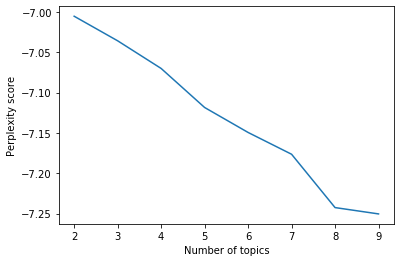

In [271]:
import matplotlib.pyplot as plt

perplexity_values = []

for i in range(2,10):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
    perplexity_values.append(ldamodel.log_perplexity(corpus))
    
x = range(2,10)
plt.plot(x, perplexity_values)
plt.xlabel('Number of topics')
plt.ylabel('Perplexity score')
plt.show()

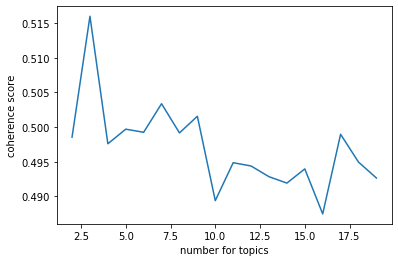

In [272]:
coherence_values = []
for i in range(2, 20):
    ldamodel = gensim.models.ldamodel.LdaModel(
        corpus, num_topics=i, id2word=dictionary)
    coherence_model_lda = CoherenceModel(
        model=ldamodel, texts=tokenized_text, dictionary=dictionary, topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

x = range(2, 20)
plt.plot(x, coherence_values)
plt.xlabel('number for topics')
plt.ylabel('coherence score')
plt.show()

In [284]:
coherence_values.index(max(coherence_values))

1

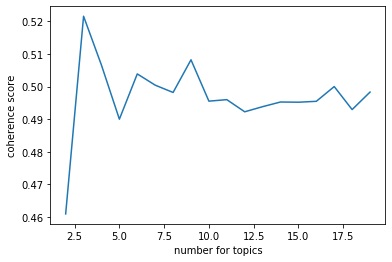

In [291]:
coherence_values = dict()
for i in range(2, 20):
    ldamodel = gensim.models.ldamodel.LdaModel(
        corpus, num_topics=i, id2word=dictionary)
    coherence_model_lda = CoherenceModel(
        model=ldamodel, texts=tokenized_text, dictionary=dictionary, topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values[i] = coherence_lda

#x = range(2, 20)
plt.plot(list(coherence_values.keys()), list(coherence_values.values()))
plt.xlabel('number for topics')
plt.ylabel('coherence score')
plt.show()

In [289]:
coherence_values.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [288]:
coherence_values.values()

dict_values([0.49663161273556244, 0.4914260675475763, 0.5036151583380775, 0.4891548707412149, 0.4976486858927189, 0.5030306453514919, 0.4912580277640547, 0.4924795008378695, 0.4913018600777642, 0.49545558818815033, 0.5004327369649098, 0.49417346848479554, 0.5081921243907608, 0.4941206579427532, 0.4963165819793495, 0.4947805747133721, 0.4865530153856166, 0.4973065018295485])

In [ ]:
#def select_team (team_name):
    
df = pd.read_excel('./kbo_news/{}.xlsx'.format(team_name),index_col=0)
df.reset_index(drop=True, inplace=True)
df.drop(list(df_1[df_1.content == 'if (deployPhase === "local" || deployPhase === "dev") {'].index), inplace=True)
df.reset_index(drop=True, inplace=True)
